In [ ]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/new_dataset64x64.hdf5'
with h5py.File(file_path, 'r') as hf:
    images = np.array(hf['images'])  # Load images (assuming it's under 'images')
    redshifts = np.array(hf['specz_redshift'])  # Load redshift labels
    redshift_err = np.array(hf['specz_redshift_err'])

Mounted at /content/drive


In [ ]:
images = images / 255.0
redshifts = (redshifts - redshifts.min()) / (redshifts.max() - redshifts.min())  # normalized the redshift values


X_train, X_val, y_train, y_val = train_test_split(images, redshifts, test_size=0.2, random_state=42)

# Data Augmentation (only applied to the high-redshift images later)
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
# Augment high-redshift galaxies   i.e > 0.5
high_z_threshold = 0.5
high_z_indices = np.where(y_train > high_z_threshold)[0]

# Augmenting high-redshift samples
X_train_high_z = X_train[high_z_indices]
y_train_high_z = y_train[high_z_indices]

# Applying data augmentation
train_gen_high_z = datagen.flow(X_train_high_z, y_train_high_z, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1338, 5, 64, 64) (64 channels).
  warnings.warn(


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_model():
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 5)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the data
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))  # Output layer for regression (redshift prediction)

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model


In [ ]:
import h5py
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

with h5py.File(file_path, 'r') as hf:
    images = np.array(hf['images'])
    redshifts = np.array(hf['specz_redshift'])


images = np.transpose(images, (0, 2, 3, 1))


images = images / 255.0
redshifts = (redshifts - redshifts.min()) / (redshifts.max() - redshifts.min())

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(images, redshifts, test_size=0.2, random_state=42)


def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(64, 64, 5)))
    model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model


model = create_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 0.0269 - mae: 0.1255 - val_loss: 0.0093 - val_mae: 0.0725
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0108 - mae: 0.0796 - val_loss: 0.0073 - val_mae: 0.0654
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0721 - val_loss: 0.0067 - val_mae: 0.0621
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0691 - val_loss: 0.0066 - val_mae: 0.0620
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0074 - mae: 0.0655 - val_loss: 0.0059 - val_mae: 0.0583
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0069 - mae: 0.0638 - val_loss: 0.0055 - val_mae: 0.0559
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0064 - mae: 0.0613 - val_loss: 0.0049 - val_mae: 0.0525
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0059 - mae: 0.0593 - val_loss: 0.0045 - val_mae: 0.0500
Epoch 9/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8m

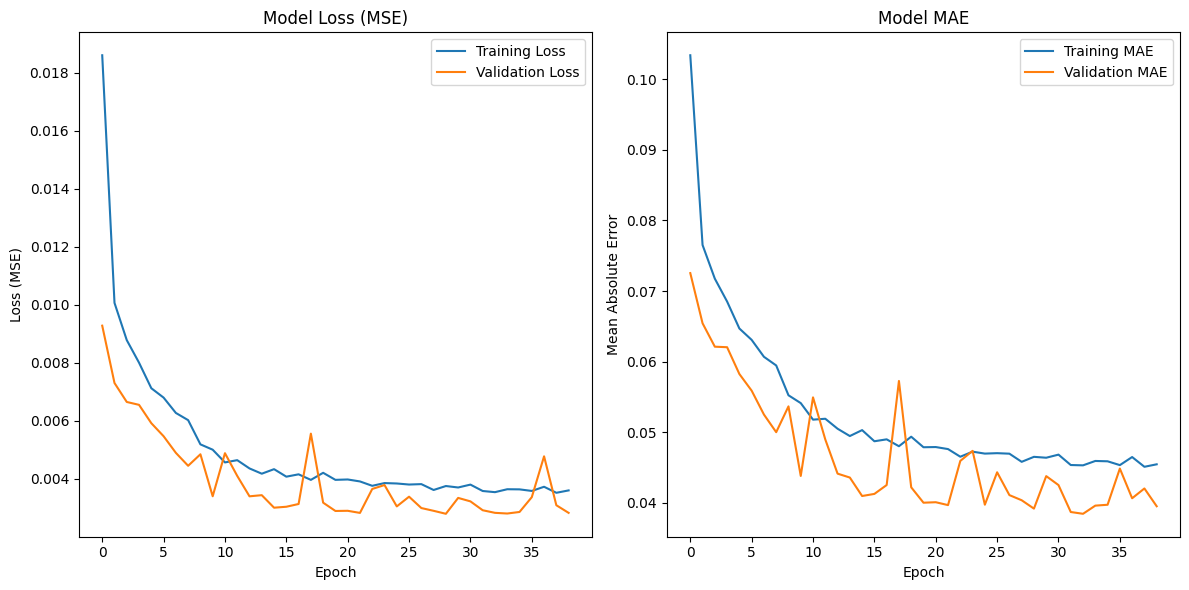

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


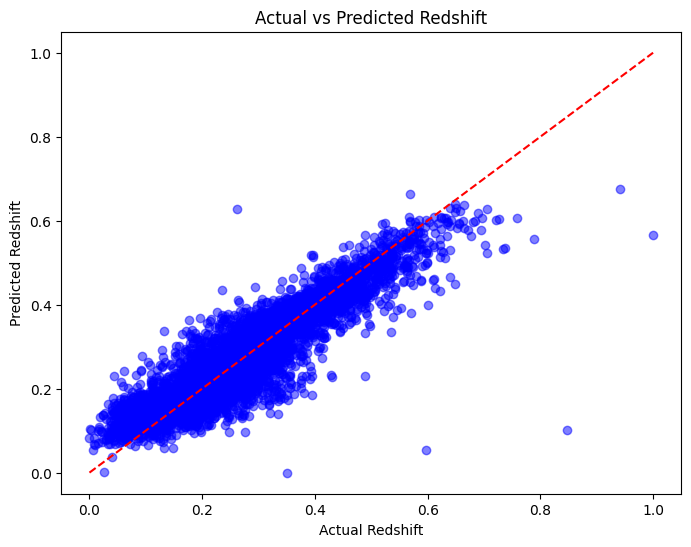

In [ ]:
y_pred = model.predict(X_val)

plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.5, color='b')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.title('Actual vs Predicted Redshift')
plt.xlabel('Actual Redshift')
plt.ylabel('Predicted Redshift')
plt.show()

In [ ]:
import pandas as pd
import numpy as np


mse = np.mean((y_val - y_pred) ** 2)

bias = np.mean(y_val - y_pred)

variance = np.var(y_pred)

results = {
    'Metric': ['MSE', 'Bias', 'Variance (sigma^2)'],
    'Value': [mse, bias, variance]
}

results_df = pd.DataFrame(results)

print(results_df)



               Metric     Value
0                 MSE  0.029722
1                Bias -0.002178
2  Variance (sigma^2)  0.013321


In [ ]:
from tabulate import tabulate
import numpy as np

mse = np.mean((y_val - y_pred) ** 2)

bias = np.mean(y_val - y_pred)

variance = np.var(y_pred)

table_data = [
    ['MSE', mse],
    ['Bias', bias],
    ['Variance (sigma^2)', variance]
]

table = tabulate(table_data, headers=['Metric', 'Value'], tablefmt='fancy_grid')

print(table)


╒════════════════════╤═════════════╕
│ Metric             │       Value │
╞════════════════════╪═════════════╡
│ MSE                │  0.0297225  │
├────────────────────┼─────────────┤
│ Bias               │ -0.00217795 │
├────────────────────┼─────────────┤
│ Variance (sigma^2) │  0.0133208  │
╘════════════════════╧═════════════╛
